In [1]:
import sys
import os
import tensorflow as tf
import pandas as pd
import nrrd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
sys.path.insert(0, os.path.abspath('..'))
import resample
from collections import namedtuple
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score
from scipy import ndimage

2021-09-03 12:02:54.542578: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
df = pd.read_csv('/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512_seg_test_sev.csv')
print(df)

                                                   img  \
0    /work/jprieto/data/remote/EGower/jprieto/eyes_...   
1    /work/jprieto/data/remote/EGower/jprieto/eyes_...   
2    /work/jprieto/data/remote/EGower/jprieto/eyes_...   
3    /work/jprieto/data/remote/EGower/jprieto/eyes_...   
4    /work/jprieto/data/remote/EGower/jprieto/eyes_...   
..                                                 ...   
335  /work/jprieto/data/remote/EGower/jprieto/eyes_...   
336  /work/jprieto/data/remote/EGower/jprieto/eyes_...   
337  /work/jprieto/data/remote/EGower/jprieto/eyes_...   
338  /work/jprieto/data/remote/EGower/jprieto/eyes_...   
339  /work/jprieto/data/remote/EGower/jprieto/eyes_...   

                                                   seg  \
0    /work/jprieto/data/remote/EGower/jprieto/Segme...   
1    /work/jprieto/data/remote/EGower/jprieto/Segme...   
2    /work/jprieto/data/remote/EGower/jprieto/Segme...   
3    /work/jprieto/data/remote/EGower/jprieto/Segme...   
4    /work/jp

In [13]:
model = tf.keras.models.load_model('/work/jprieto/data/remote/EGower/jprieto/trained/eyes_cropped_resampled_512_seg_train_08282021', custom_objects={'tf': tf})
model.summary()

2021-09-03 09:42:51.558080: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-03 09:42:51.565720: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-03 09:42:51.632363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2021-09-03 09:42:51.632874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro P600 computeCapability: 6.1
coreClock: 1.5565GHz coreCount: 3 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 59.75GiB/s
2021-09-03 09:42:51.632895: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-03 09:42:51.639625:

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 256, 256, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [31]:
row = df.iloc[33]
y_pred_arr = []
y_true_arr = []
dice_arr = []

for idx, row in df.iterrows():
    img = row["img"]
    seg = row["seg"]
    print(img)
    img_np, header = nrrd.read(img, index_order='C')
    y_true, header = nrrd.read(seg, index_order='C')
    
    y_pred = model.predict(np.expand_dims(img_np, axis=0))
    
    y_pred = np.reshape(y_pred, -1)
    y_true = np.reshape(y_true, -1)
    
    jaccard = jaccard_score(y_true, y_pred, average=None)
    dice = 2.0*jaccard/(1.0 + jaccard)
    if(len(dice) == 4):
        print(dice)
        dice_arr.append(dice)
    else:
        dice_arr.append([0, 0, 0, 0])
        print("WTF!", row["img"])

/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11015_11Pre_os_upper_cropped.nrrd
[0.99523551 0.95326958 0.95711029 0.93442341]
/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11047_11Pre_od_upper_cropped.nrrd
[0.98457117 0.9412361  0.9573005  0.74997529]
/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11074_11Pre_od_upper_cropped.nrrd
[0.98911603 0.94887521 0.94771158 0.92299383]
/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11079_11Pre_os_upper_cropped.nrrd
[0.98865313 0.82708203 0.97043933 0.75883267]
/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11081_11Pre_os_upper_cropped.nrrd
[0.98972465 0.76633369 0.8563334  0.80083379]
/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11089_11Pre_od_upper_cropped.nrrd
[0.99465059 0.71143847 0.95864491 0.87154266]
/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11093_11Pre_os_upper_cropped.nrrd
[0.9933702

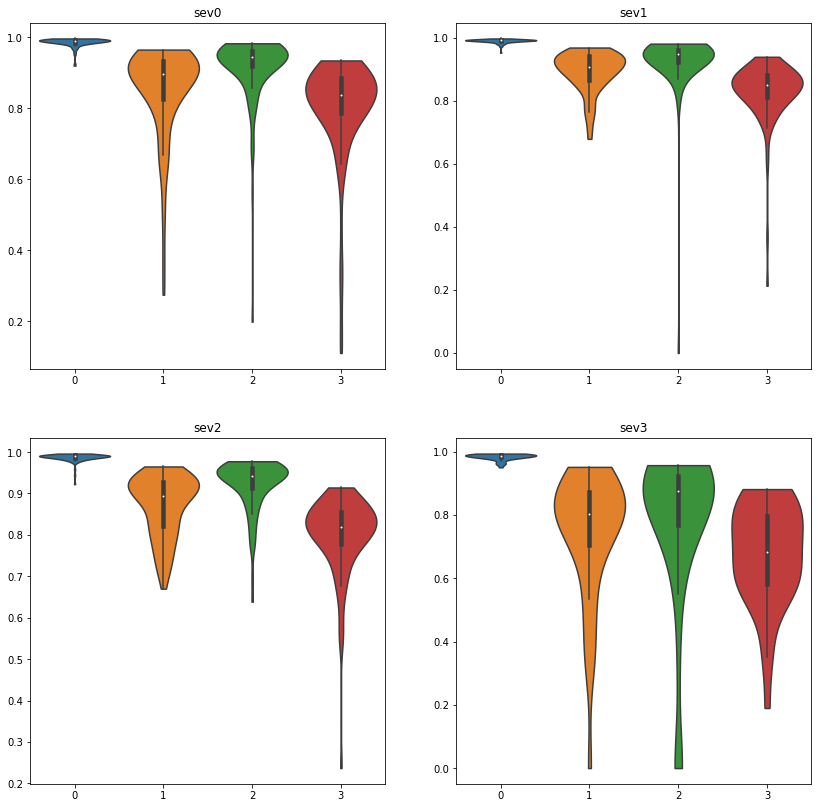

In [47]:
df["dice_arr"] = dice_arr
df_group_sev = df.groupby("severity_class")

fig, axs = plt.subplots(2,2, figsize=(14,14))
for k in df_group_sev.groups.keys():
    df_sev = df_group_sev.get_group(k)
    d_arr = list(df_sev["dice_arr"])
    d_arr = np.array(d_arr)
    ax = axs[int(k/2),int(k%2)]
    ax.set_title('sev' + str(k))
    s = sns.violinplot(data=d_arr, cut=0, scale="count", ax=ax)

In [48]:

y_pred = model.predict(np.expand_dims(img_np, axis=0))

label_num = 3
size = 32
neigborhood = int(size/2)
num_samples = 32

seg_np = np.squeeze(prediction[0], axis=-1)
y, x = np.where(seg_np == label_num)
z = np.polyfit(x, y, 3)
poly = np.poly1d(z)

min_x = np.min(x) + neigborhood
max_x = np.max(x) - neigborhood
max_y = np.max(y) - neigborhood
dx = (max_x - min_x)/num_samples

out_stack = []
x_values = []
y_values = []
for i in range(num_samples):
    x = min_x + i*dx
    y = poly(x)

    x_values.append(x)
    y_values.append(y)

    start_x = min(max(int(x) - neigborhood, 0), max_x  - neigborhood)
    start_y = min(max(int(y) - neigborhood, 0), max_y  - neigborhood)

    end_x = start_x + size
    end_y = start_y + size


    out_stack.append(img_np[start_y:end_y,start_x:end_x,:])

NameError: name 'prediction' is not defined

/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11015_11Pre_os_upper_cropped.nrrd


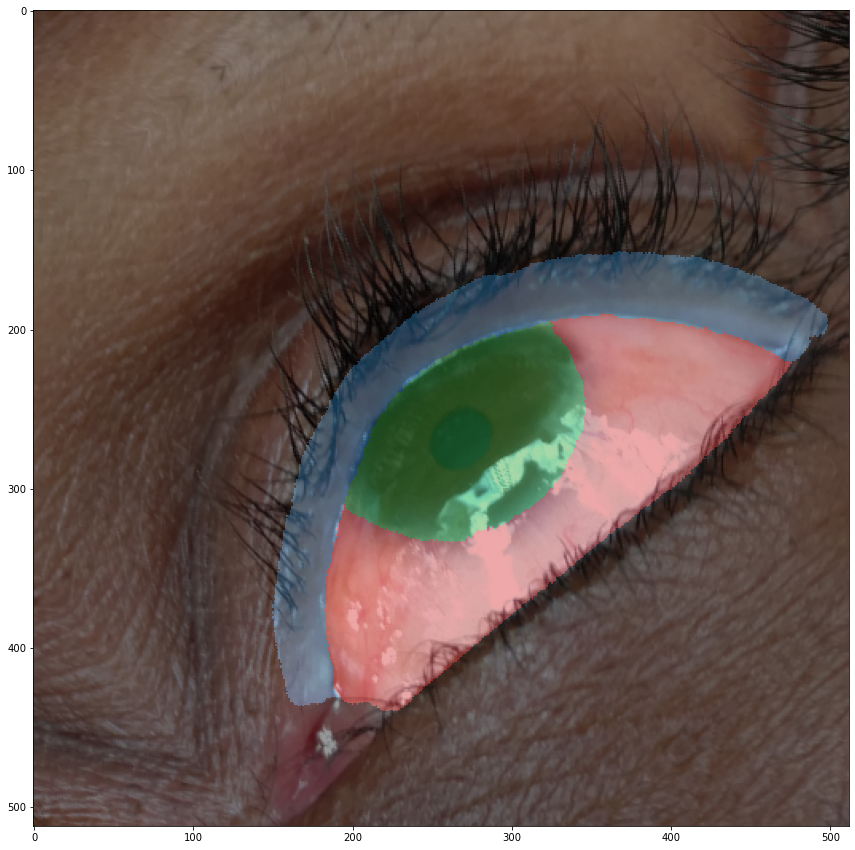

In [16]:
row = df.iloc[0]
img = row["img"]
seg = row["seg"]
print(img)
img_np, header = nrrd.read(img, index_order='C')
seg_np, header = nrrd.read(seg, index_order='C')

degree = np.random.random() * 180 - 90 
img_np = ndimage.rotate(img_np, degree, reshape=False, 
                mode='reflect')
seg_np = ndimage.rotate(seg_np, degree, reshape=False,
                mode='constant', order=0, cval=0)

cmap = ListedColormap(["black", "tab:red", "tab:green", "tab:blue"])
plt.figure(figsize = (15,15))
plt.imshow(img_np)
plt.imshow(seg_np, cmap=cmap, interpolation='nearest', alpha=0.4)
# plt.plot(x_values, y_values, linewidth=2, color="red")
plt.show()

In [20]:
df1 = pd.read_csv("/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512_seg_test.csv")
df2 = pd.read_csv("/work/jprieto/data/remote/EGower/jprieto/trachoma_normals_healthy_sev123_05182021_prediction_09072021.csv")
df = df1.merge(df2, on='img')
print(df1)
print(df2)
print(df)


                                                   img  \
0    /work/jprieto/data/remote/EGower/jprieto/eyes_...   
1    /work/jprieto/data/remote/EGower/jprieto/eyes_...   
2    /work/jprieto/data/remote/EGower/jprieto/eyes_...   
3    /work/jprieto/data/remote/EGower/jprieto/eyes_...   
4    /work/jprieto/data/remote/EGower/jprieto/eyes_...   
..                                                 ...   
335  /work/jprieto/data/remote/EGower/jprieto/eyes_...   
336  /work/jprieto/data/remote/EGower/jprieto/eyes_...   
337  /work/jprieto/data/remote/EGower/jprieto/eyes_...   
338  /work/jprieto/data/remote/EGower/jprieto/eyes_...   
339  /work/jprieto/data/remote/EGower/jprieto/eyes_...   

                                                   seg  
0    /work/jprieto/data/remote/EGower/jprieto/Segme...  
1    /work/jprieto/data/remote/EGower/jprieto/Segme...  
2    /work/jprieto/data/remote/EGower/jprieto/Segme...  
3    /work/jprieto/data/remote/EGower/jprieto/Segme...  
4    /work/jprieto

In [22]:
y_pred_arr = []
y_true_arr = []
dice_arr = []

for idx, row in df.iterrows():
    seg = row["seg"]
    pred = row["prediction"]
    print(img)
    pred_np, header = nrrd.read(pred, index_order='C')
    seg_np, header = nrrd.read(seg, index_order='C')
    
    pred_np = np.reshape(pred_np, -1)
    seg_np = np.reshape(seg_np, -1)
    
    jaccard = jaccard_score(seg_np, pred_np, average=None)
    dice = 2.0*jaccard/(1.0 + jaccard)
    if(len(dice) == 4):
        print(dice)
        dice_arr.append(dice)
    else:
        dice_arr.append([0, 0, 0, 0])
        print("WTF!", row["img"])

/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11015_11Pre_os_upper_cropped.nrrd
[0.99277055 0.94341288 0.94185398 0.93336256]
/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11015_11Pre_os_upper_cropped.nrrd
[0.99300297 0.95617247 0.96308152 0.88160035]
/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11015_11Pre_os_upper_cropped.nrrd
[0.99026512 0.9543772  0.95132185 0.93499323]
/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11015_11Pre_os_upper_cropped.nrrd
[0.99189371 0.94675643 0.97460304 0.8841548 ]
/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11015_11Pre_os_upper_cropped.nrrd
[0.98965839 0.77949187 0.83218197 0.84411184]
/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11015_11Pre_os_upper_cropped.nrrd
[0.99463196 0.82289562 0.95425773 0.89333504]
/work/jprieto/data/remote/EGower/jprieto/eyes_cropped_resampled_512/11015_11Pre_os_upper_cropped.nrrd
[0.9945846

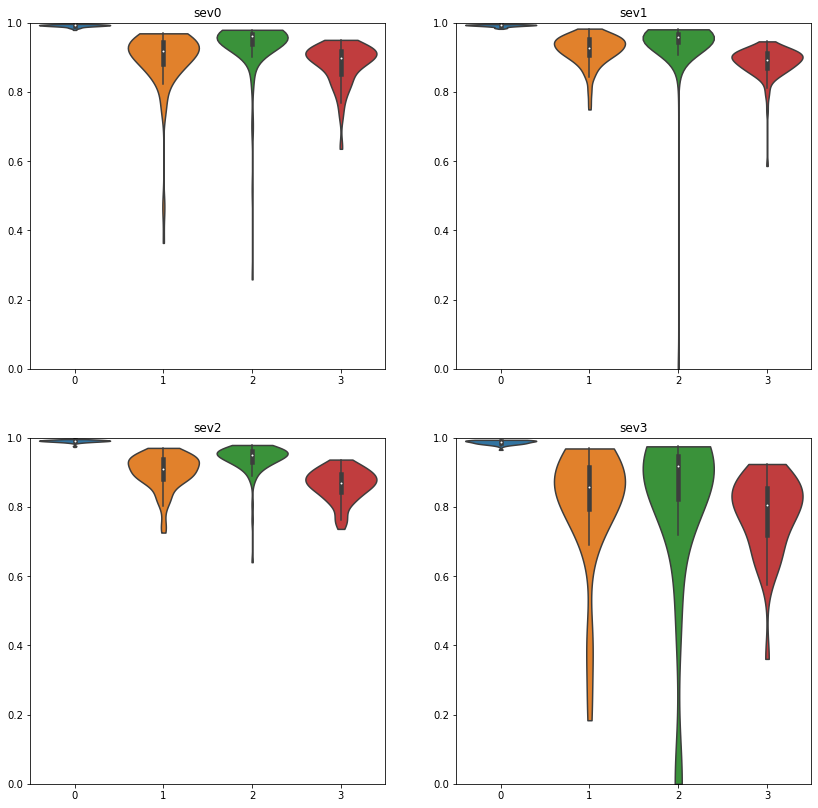

In [35]:
df["dice_arr"] = dice_arr
df_group_sev = df.groupby("severity_class")

fig, axs = plt.subplots(2,2, figsize=(14,14))
for k in df_group_sev.groups.keys():
    df_sev = df_group_sev.get_group(k)
    d_arr = list(df_sev["dice_arr"])
    d_arr = np.array(d_arr)
    ax = axs[int(k/2),int(k%2)]
    ax.set_title('sev' + str(k))
    ax.set_ylim([0, 1])
    s = sns.violinplot(data=d_arr, cut=0, scale="count", ax=ax)

In [56]:
for k in df_group_sev.groups.keys():
    df_sev = df_group_sev.get_group(k)
    d_arr = list(df_sev["dice_arr"])
    d_arr = np.array(d_arr)
    print("k:", k, "mean:", np.mean(d_arr, axis=0), "std:", np.std(d_arr, axis=0))
    
d_arr = list(df["dice_arr"].apply(list))
print("mean:", np.mean(d_arr, axis=0), "std:", np.std(d_arr, axis=0))

k: 0 mean: [0.99165944 0.89512474 0.93597241 0.88006698] std: [0.00359138 0.0923742  0.08865279 0.05923246]
k: 1 mean: [0.99198138 0.92101033 0.94265764 0.88491914] std: [0.00316619 0.04340353 0.09988481 0.04510945]
k: 2 mean: [0.99107005 0.90200633 0.94016921 0.86441701] std: [0.00375969 0.05061002 0.04438975 0.04571478]
k: 3 mean: [0.98749375 0.80693323 0.80643063 0.77939088] std: [0.0058778  0.17831954 0.25762077 0.11128845]
mean: [0.99109116 0.89394528 0.92379745 0.86511364] std: [0.00410389 0.09393027 0.12449061 0.06914911]
